# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.1.0+cu121


'cpu'

## 1. What are 3 areas in industry where computer vision is currently being used?

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [77]:
from torchvision.datasets import MNIST
from torchvision import transforms
train_data = MNIST(root='data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = MNIST(root='data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
print('train:', train_data.data.shape)
print('test:', test_data.data.shape)

train: torch.Size([60000, 28, 28])
test: torch.Size([10000, 28, 28])


## 6. Visualize at least 5 different samples of the MNIST training dataset.

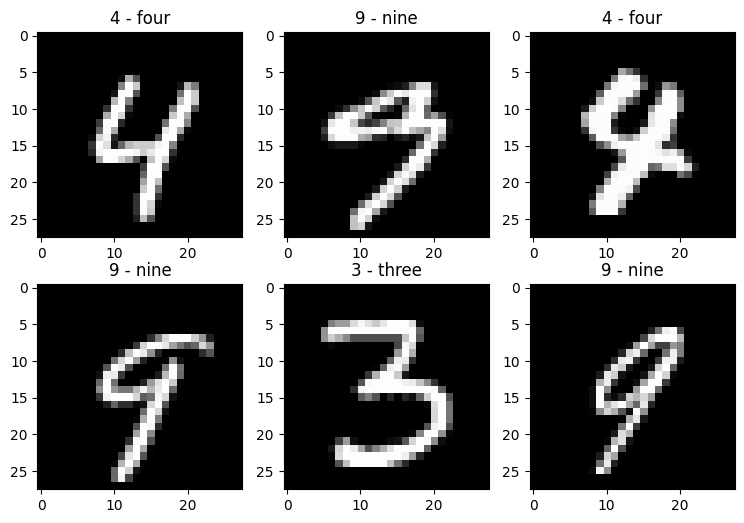

In [78]:
import matplotlib.pyplot as plt
# class and index
classes = train_data.classes
random_idx = torch.randint(low=0, high=60000, size=(1,6)).squeeze()

# sample data
sample_data = train_data.data[random_idx]
sample_target = train_data.targets[random_idx]

# plot
plt.figure(figsize=(9, 6))
nrows=2
ncols=3
for i, data in enumerate(sample_data):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample_data[i], cmap='gray')
  plt.title(classes[sample_target[i]])
plt.show()

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [219]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=False)
test_data_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [86]:
print('1 sample shape:')
next(iter(train_data_loader))[0].shape

1 sample shape:


torch.Size([32, 1, 28, 28])

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [98]:
import torch.nn as nn
# define the model
class TinyVGG(nn.Module):
  def __init__(self, in_shape=1, out_shape=10, hidden_units=16):
    super().__init__()

    self.cnn_block = nn.Sequential(
        nn.Conv2d(in_channels=in_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.mlp_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=out_shape)
    )

  def forward(self, x):
    x = self.cnn_block(x)
    x = self.mlp_block(x)
    return x

# initiate the model
model = TinyVGG().to(device)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [110]:
from sklearn.metrics import accuracy_score
import numpy as np
import time

# optimizer / loss / # epoch
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 5

# Training
start = time.time()
for epoch in range(epochs):
  train_losses = []
  test_losses = []
  accuracies = []

  # Train
  model.train()

  # train on each batch
  for X, y in train_data_loader:
    X, y = X.to(device), y.to(device)

    # predit
    y_logit = model(X)

    # loss
    loss = loss_fn(y_logit, y)
    train_losses.append(loss.cpu().detach().numpy())

    # optimizer zero grad
    optimizer.zero_grad()

    # gradient
    loss.backward()

    # optimizer step
    optimizer.step()

  # Test
  model.eval()

  # test on each batch
  with torch.inference_mode():
    for X, y in test_data_loader:
      X, y = X.to(device), y.to(device)

      # predict
      y_logit = model(X)

      # add loss
      test_losses.append(loss_fn(y_logit, y).cpu().detach().numpy())

      # add accuracy
      accuracies.append(accuracy_score(y.cpu().detach().numpy(), torch.argmax(y_logit, dim=1).cpu().detach().numpy()))

  # print stats on each epoch
  print(f"Epoch {epoch+1}: \t Accuracy-{np.mean(accuracies):.4} \t Train loss-{np.mean(train_losses):.4} \t Test loss- {np.mean(test_losses):.4}")
end = time.time()
print(f"Training time: {(end-start):.3} seconds")

Epoch 1: 	 Accuracy-0.9714456869009584 	 Train loss-0.09101275354623795 	 Test loss- 0.0972398892045021
Epoch 2: 	 Accuracy-0.9755391373801917 	 Train loss-0.088365338742733 	 Test loss- 0.07545249164104462
Epoch 3: 	 Accuracy-0.9747404153354633 	 Train loss-0.08638978004455566 	 Test loss- 0.08052616566419601
Epoch 4: 	 Accuracy-0.9694488817891374 	 Train loss-0.0864616259932518 	 Test loss- 0.107436403632164
Epoch 5: 	 Accuracy-0.9722444089456869 	 Train loss-0.08420616388320923 	 Test loss- 0.10287509858608246
Training time: 358.6796622276306 seconds


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [161]:
# Test
model.eval()

# test on each batch
y_true = torch.tensor([])
y_pred = torch.tensor([])


with torch.inference_mode():
  for X, y in test_data_loader:
    X, y = X.to(device), y.to(device)

    # predict
    y_logit = model(X)
    y_pred = torch.argmax(y_logit, dim=1)

    # add accuracy
    accuracies.append(accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy()))

# print test set accuracy
print(f"Test set accuracy-{np.mean(accuracies):.4}")

Test set accuracy-0.9723


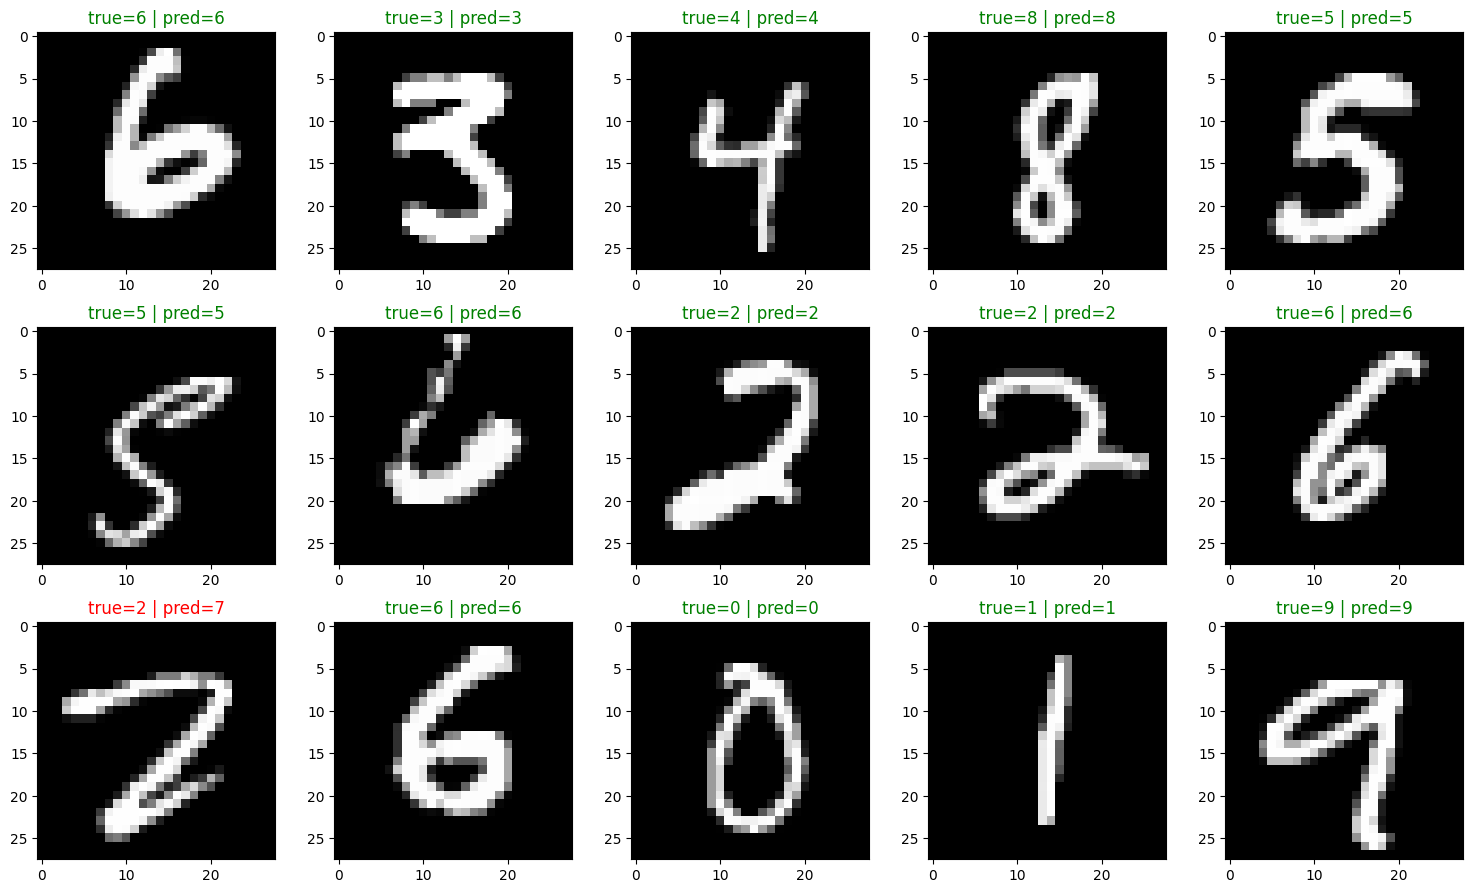

In [216]:
import random

# get sample
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=15):
    test_samples.append(sample)
    test_labels.append(label)

# get predictions
pred_labels = []
with torch.inference_mode():
  for sample in test_samples:
    y_logit = model(sample.unsqueeze(dim=1))
    pred_labels.append(torch.argmax(y_logit, dim=1).cpu().item())

# plot
plt.figure(figsize=(15, 9))
nrows=3
ncols=5
for i, data in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(test_samples[i].squeeze(), cmap='gray')
  # title
  if test_labels[i] == pred_labels[i]:
    plt.title(f"true={test_labels[i]} | pred={pred_labels[i]}", c='g')
  else:
    plt.title(f"true={test_labels[i]} | pred={pred_labels[i]}", c='r')
plt.tight_layout()
plt.show()

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [220]:
# get predictions
pred_targets = []
model.eval()
with torch.inference_mode():
  for X, y in test_data_loader:
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)

    # Predict
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    pred_targets.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(pred_targets)

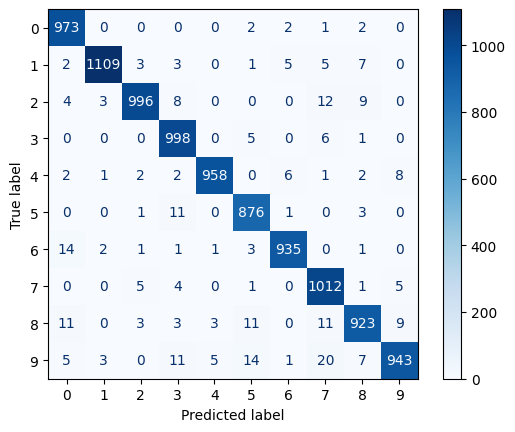

In [225]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_data.targets, y_pred_tensor)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?